In [17]:
import cv2
import numpy as np

In [18]:
cv2.__version__

'3.4.2'

In [19]:
img1 = cv2.imread("E:/Computer Vision/CSE473573Project_2_Sample_Test/data/nevada3.jpg")
#img1 = cv2.resize(img1, (int(img1.shape[0]/4),int(img1.shape[1]/4)))
img1_gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
img1_gray.shape

(2592, 3888)

In [32]:
img2 = cv2.imread("E:/Computer Vision/CSE473573Project_2_Sample_Test/data/nevada5.jpg")
#img2 = cv2.resize(img2, (int(img2.shape[0]/4),int(img2.shape[1]/4)))
img2_gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
img2_gray.shape

(2592, 3888)

In [33]:
sift = cv2.xfeatures2d.SIFT_create()

In [34]:
keypoints1, descriptors1 = sift.detectAndCompute(img1_gray, None)

In [35]:
keypoints2, descriptors2 = sift.detectAndCompute(img2_gray, None)

In [36]:
from heapq import nsmallest

In [37]:
#Checking for matches using SIFT Features
def check_matches(descriptors1, descriptors2):
    
    matches_index = []
    for i in range(descriptors2.shape[0]):
        distances = np.linalg.norm(descriptors1 - descriptors2[i], axis = 1)
        two_smallest = nsmallest(2,distances)
        min1, min2 = two_smallest[0] , two_smallest[1]
        ratio = min1/min2
        if ratio > 0.5:
            continue
        else:
            min_index = np.argmin(distances)
            matches_index.append((i,min_index))
    print(len(matches_index))
    ratio = len(matches_index)/ descriptors1.shape[0]
    print(ratio)
    return ratio,matches_index


In [38]:
# Obtaining the matched points
ratio, matches_index = check_matches(descriptors1, descriptors2)
src_indices = [l[0] for l in matches_index]
dest_indices = [l[1] for l in matches_index]
src_points = np.float32([keypoints2[index].pt for index in src_indices])
dest_points = np.float32([keypoints1[index].pt for index in dest_indices])
print(src_points.shape)
print(dest_points.shape)

256
0.16987392169873922
(256, 2)
(256, 2)


In [39]:
def calculate_Homography(pts1,pts2):
    A = []
    for i in range(len(pts1)):
        x1 = pts1[i][0]
        y1 = pts1[i][1]
        x2 = pts2[i][0]
        y2 = pts2[i][1]
        A.append([x1, y1, 1, 0, 0, 0, -1 * x2 * x1 , -1 * x2 * y1 , -1 * x2])
        A.append([0 , 0 , 0 , x1, y1, 1, -1 * y2 * x1, -1 * y2 * y1, -1 * y2])
        
    u,s,vh = np.linalg.svd(A)
    #print(vh[-1,:].shape)
    H = vh[-1,:]/vh[-1,-1]
    H = H.reshape(3,3)
    return H

In [40]:
def get_RANSAC(src_points, dest_points):
    trials = 500
    column_ones = np.ones(src_points.shape[0])
    column_ones = column_ones.reshape(dest_points.shape[0],1)
    src_points2 = np.append(src_points, column_ones, axis = 1)
    src_points2 = src_points2.T
    dest_points2 = np.append(dest_points, column_ones, axis = 1)
    dest_points2 = dest_points2.T
    final_H = np.ones((3,3))
    inlier_f = int(0.9 * len(src_points))
    for i in range(trials):
        index_rand = np.random.randint(0, len(src_points), size = 4)
        pts1 = src_points[index_rand] # Points which matched in right image
        pts2 = dest_points[index_rand]
        H = calculate_Homography(pts1,pts2)
        c_ones = np.ones(pts1.shape[0])
        c_ones = c_ones.reshape(c_ones.shape[0],1)
        pts1_1 = np.append(pts1, c_ones, axis =1)
        pts1_1 = pts1_1.T
        pts2_2 = np.append(pts2, c_ones, axis =1)
        pts2_2 = pts2_2.T
        dists = []
        for j in range(pts1_1.shape[1]):
            dist = np.linalg.norm(pts2_2[:,j] - np.dot(H, pts1_1[:,j]))
            dists.append(dist)
        dists = np.asarray(dists)
        threshold = np.max(dists)
        distances = []
        for j in range(src_points2.shape[1]):
            src = np.dot(H,src_points2[:,j])
            distance = np.linalg.norm(dest_points2[:,j] - src)
            distances.append(distance)
        distances = np.asarray(distances)
        inliers_src = []
        inliers_dest = []
        inliers = 0
        for j in range(distances.shape[0]):
            if distances[j] < threshold:
                inliers_src.append(src_points[j])
                inliers_dest.append(dest_points[j])
                inliers += 1
        inliers_src = np.asarray(inliers_src)
        inliers_dest = np.asarray(inliers_dest)
        if inliers > inlier_f:
            final_H = calculate_Homography(inliers_src, inliers_dest)
            inlier_f = inliers
            break
    return final_H
         

In [41]:
H = get_RANSAC(src_points, dest_points)


In [30]:
def trim(frame):
    #crop top
    if not np.sum(frame[0]):
        return trim(frame[1:])
    #crop bottom
    if not np.sum(frame[-1]):
        return trim(frame[:-2])
    #crop top
    if not np.sum(frame[:,0]):
        return trim(frame[:,1])
    #crop top
    if not np.sum(frame[:,-1]):
        return trim(frame[:,:-2])
    return frame

(2592, 5926, 3)


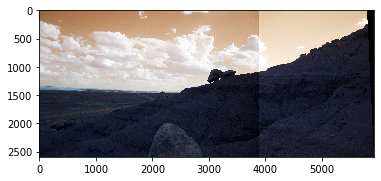

In [47]:
import matplotlib.pyplot as plt
import sys 
sys.setrecursionlimit(10**6)
#dst1 = cv2.warpPerspective(img1,np.linalg.inv(H), (img1.shape[1], img1.shape[0]))
#dst1 = trim(dst1)
dst2 = cv2.warpPerspective(img2,H,(img1.shape[1] + img2.shape[1],img2.shape[0]))
dst2[0:img1.shape[0],0:img1.shape[1]] = img1
dst2 = trim(dst2)
cv2.imwrite("E:/stitched_image4.jpg", dst2)
print(dst2.shape)
plt.imshow(dst2)
plt.show()